In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import geoplot as gplt
import geopandas as gpd
from rasterio.crs import CRS
# import earthpy as et
import pandas as pd
# import utm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
# import seaborn as sns
from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib.patches import Patch
import unicodedata
from matplotlib.patches import Polygon ## for polygons

import json ## used for importing JSONs
try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
    
def removeDiacritics(string):
    """
    Removes diacritic marks from unicode.
    """
    return unicodedata.normalize('NFKD', string)

import geoplot.crs as gcrs
import warnings
warnings.filterwarnings('ignore')

# 1. load distribution data

In [5]:
%%bash
ls cgrs_grid/*shp

cgrs_grid/cgrs_grid.shp
cgrs_grid/ne_110m_admin_0_boundary_lines_land.shp
cgrs_grid/ne_110m_admin_0_countries_lakes.shp


In [6]:
# world = gpd.read_file('./cgrs_grid/ne_110m_admin_0_boundary_lines_land.shp')
world = gpd.read_file('./cgrs_grid/ne_110m_admin_0_countries_lakes.shp')
grid = gpd.read_file('./cgrs_grid/cgrs_grid.shp')

GEOGCS["WGS84 Lat/Long's, Degrees, -180 ==> +180",DATUM["WGS_1984",SPHEROID["World Geodetic System of 1984",6378137,298.257222932867],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


<Axes: >

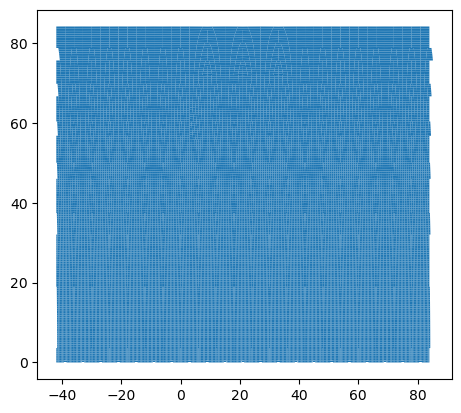

In [7]:
print(grid.crs)
grid.plot()

In [8]:
grid
str(grid['geometry'][0].area)

'0.13769284949999988'

In [9]:
grid.columns

Index(['CGRSNAME', 'CGRSTYPE', 'geometry'], dtype='object')

In [10]:
# upload reference file
ref=pd.read_csv('./reference_cgrs_WM.csv', sep='|')
refdict=dict(zip(ref['CGRSNAME'],ref['GridNr']))
ref

cat  GridNr   long    lat CGRSNAME
0        1       1  16.90  39.70   33SXD3
1        2       2  16.80  39.44   33SXD3
2        3       3  19.30  38.58   34SCH3
3        4       4  19.95  39.05   34SDJ2
4        5       5  19.95  38.66   34SDH1
...    ...     ...    ...    ...      ...
4414  4415    4415  64.85  68.72   41WNS4
4415  4416    4416  63.64  69.63   41WNT2
4416  4417    4417  66.00  67.37   41WPQ1
4417  4418    4418  66.00  68.27   41WPR1
4418  4419    4419  66.00  67.82   41WPR2

[4419 rows x 5 columns]

In [11]:
# add a column to shape file with GridNr
grid['GridNr']=''
for index,row in enumerate(grid.itertuples()):
    grid.loc[index,'GridNr']=refdict[row.CGRSNAME] if row.CGRSNAME in refdict.keys() else np.nan
#     print(index)
grid

CGRSNAME               CGRSTYPE  \
0       24NSF3  independent seam cell   
1       24NSF4  independent seam cell   
2       24NSG3  independent seam cell   
3       24NSG4  independent seam cell   
4       24NSH3  independent seam cell   
...        ...                    ...   
35624   44XNS1  independent seam cell   
35625   44XNS2  independent seam cell   
35626   44XNT1  independent seam cell   
35627   44XNT2  independent seam cell   
35628   44XNU2  independent seam cell   

                                                geometry GridNr  
0      POLYGON ((-42.00000 0.45174, -42.00000 0.90348...    NaN  
1      POLYGON ((-42.00000 0.00000, -42.00000 0.45174...    NaN  
2      POLYGON ((-42.00000 1.35522, -42.00000 1.80696...    NaN  
3      POLYGON ((-42.00000 0.90348, -42.00000 1.35522...    NaN  
4      POLYGON ((-42.00000 2.25870, -42.00000 2.71043...    NaN  
...                                                  ...    ...  
35624  POLYGON ((81.00000 82.40465, 81.00000 82.85256...    NaN  
35625  POLYGON ((81.00000 81.95674, 81.00000 82.40465...    NaN  
35626  POLYGON ((81.00000 83.30046, 81.00000 83.74835...    NaN  
35627  POLYGON ((81.00000 82.85256, 81.00000 83.30046...    NaN  
35628  POLYGON ((81.00000 83.74835, 81.00000 84.19662...    NaN  

[35629 rows x 4 columns]

<Axes: >

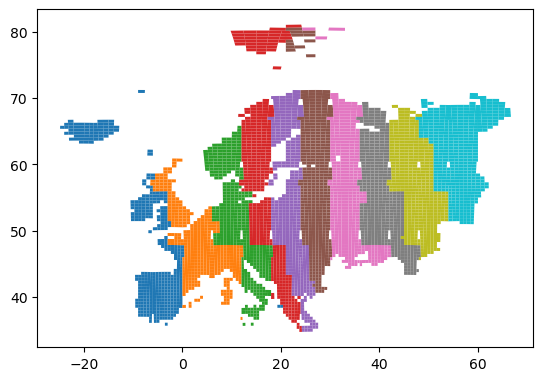

In [12]:
grid.plot('GridNr')

# 2. Load species list and distribution data

In [14]:
# spp_list=pd.read_csv('./matching_sp_list.txt', sep='\t')
spp_list=pd.read_csv('./matching_sp_list_kudrna.txt', sep='\t')

# traits: name as it appears in the trait file; map: name as it appears in the species distribution data above
spp_list_dict=dict(zip(spp_list['traits'],spp_list['maps']))
spp_list#.head(5)

traits                    maps
0            Aglais_io               Aglias_io
1       Aglais_urticae          Aglais_urticae
2      Agriades_aquilo         Plebejus_aquilo
3    Agriades_dardanus       Plebejus_dardanus
4     Agriades_glandon        Plebejus_glandon
..                 ...                     ...
441   Zerynthia_rumina        Zerynthia_rumina
442    Zizeeria_knysna         Zizeeria_knysna
443                NaN    Hipparchia_sbordonii
444                NaN  Polyommatus_corydonius
445                NaN         Proterebia_afer

[446 rows x 2 columns]

In [18]:
# alltraits.loc[alltraits[alltraits['maps'] == 'Archon_apollinus'].index,'voltinism'].values[0]
dictref={value:key for key,value in refdict.items()}
# dictref

In [19]:
spp_dist=pd.read_csv('./Schmetterlinge_Kudrna2011_v6.csv',sep=',',names=['spp','spp_num','GridNr'])

spp_dist['CGRSNAME']=''
spp_dist['maps']=''
for index,row in enumerate(spp_dist.itertuples()):
    spp_dist.loc[index,'CGRSNAME']=dictref[row.GridNr] if row.GridNr in dictref.keys() else np.nan
    spp_dist.loc[index,'maps']=spp_list_dict[row.spp] if row.spp in spp_list_dict.keys() else np.nan
spp_dist

spp spp_num  GridNr CGRSNAME                  maps
0              Aricia_nicias  (#076)     565   31TCG3         Aricia_nicias
1              Aricia_nicias  (#076)     568   31TCH2         Aricia_nicias
2              Aricia_nicias  (#076)     569   31TCH3         Aricia_nicias
3              Aricia_nicias  (#076)     570   31TCH4         Aricia_nicias
4              Aricia_nicias  (#076)     592   31TDG1         Aricia_nicias
...                      ...     ...     ...      ...                   ...
155795  Pseudochazara_graeca  (#415)    1756   34TEL1  Pseudochazara_graeca
155796  Pseudochazara_graeca  (#415)    1757   34TEL2  Pseudochazara_graeca
155797  Pseudochazara_graeca  (#415)    1758   34TEL3  Pseudochazara_graeca
155798  Pseudochazara_graeca  (#415)    1759   34TEL4  Pseudochazara_graeca
155799  Pseudochazara_graeca  (#415)    1826   34TGM2  Pseudochazara_graeca

[155800 rows x 5 columns]

# 3. Upload trait data and homogenise to names in distribution maps

In [20]:
DR=pd.read_csv('./DR.txt', sep='\t', names=['traits','DR'])
bodysize=pd.read_csv('./body_size.txt', sep='\t', names=['traits','bodysize'])
cnrate=pd.read_csv('./climaticniche_rate.txt', sep='\t', names=['traits','cnrate'])
hnbreath=pd.read_csv('./habitatniche_breadth.txt', sep='\t', names=['traits','hnbreath'])
hnrate=pd.read_csv('./habitatniche_rate.txt', sep='\t', names=['traits','hnrate'])
hpnbreath=pd.read_csv('./hostplantniche_breadth.txt', sep='\t', names=['traits','hpnbreath'])
hpnrate=pd.read_csv('./hostplantniche_rate.txt', sep='\t', names=['traits','hpnrate'])
voltinism=pd.read_csv('./voltinism.txt', sep='\t', names=['traits','voltinism'])
voltinism

traits  voltinism
0           Agriades_glandon        1.0
1        Polyommatus_admetus        1.0
2        Polyommatus_fulgens        1.0
3        Polyommatus_amandus        1.0
4    Polyommatus_aroaniensis        1.0
..                       ...        ...
310           Zegris_eupheme        1.0
311         Zerynthia_cerisy        1.0
312       Zerynthia_polyxena        1.0
313         Zerynthia_rumina        1.0
314          Zizeeria_knysna        3.0

[315 rows x 2 columns]

In [21]:
hpnbreath['hpnbreath'].max()

103.984226

In [22]:
variables=[DR,bodysize,cnrate,hnbreath,hnrate,hpnbreath,hpnrate,voltinism]
names=['DR','bodysize','cnrate','hnbreath','hnrate','hpnbreath','hpnrate','voltinism'] # make sure this coincide with the headers in the tables

# for data in [DR,bodysize,cnrate,hnbreath,hnrate,hpnbreath,hpnrate,voltinism]:
# create dictionaries
alltraits={}
for index,data in enumerate(variables):
    print('Unique species: ',len(data['traits'].dropna().unique()))
    alltraits[names[index]]=dict(zip(data['traits'],data[names[index]]))
alltraits # this dict contains all data

# making dict with data within a 95% range before transformation
alltraits95={}
for index,data in enumerate(variables):
    q0225=data[names[index]].quantile(0.05) # not changing variable names but changing how much we trimmed
    q0975=data[names[index]].quantile(0.95) # not changing variable names but changing how much we trimmed
    
    temp = data[ (data[names[index]] > q0225) & (data[names[index]] < q0975)]
#     print(temp)
    alltraits95[names[index]]=dict(zip(temp['traits'],temp[names[index]]))
# alltraits95 # this dict contains all data

Unique species:  440
Unique species:  315
Unique species:  395
Unique species:  369
Unique species:  367
Unique species:  314
Unique species:  314
Unique species:  315


# 4. map traits in Dataframe, aggregate (mean, median) and map 

**First, a test**

In [23]:
grid.head(5)
grid[~grid['GridNr'].isna()]

CGRSNAME                 CGRSTYPE  \
5008    26WPT1    independent seam cell   
6552    27VVL1   normal 50 x 50 km cell   
6554    27VVL3   normal 50 x 50 km cell   
6588    27VWL1   normal 50 x 50 km cell   
6589    27VWL2   normal 50 x 50 km cell   
...        ...                      ...   
30435   41WNS4   normal 50 x 50 km cell   
30437   41WNT2   normal 50 x 50 km cell   
30454   41WPQ1  merged over zone border   
30456   41WPR1  merged over zone border   
30457   41WPR2  merged over zone border   

                                                geometry GridNr  
5008   POLYGON ((-24.85031 65.35747, -24.81297 65.805...     10  
6552   POLYGON ((-23.01342 63.56396, -23.04565 64.012...     11  
6554   POLYGON ((-22.00699 63.57455, -22.02312 64.023...     12  
6588   POLYGON ((-21.00000 63.57808, -21.00000 64.026...     13  
6589   POLYGON ((-21.00000 63.12934, -21.00000 63.578...     14  
...                                                  ...    ...  
30435  POLYGON ((64.22296 68.50800, 64.24778 68.95632...   4415  
30437  POLYGON ((63.00000 69.40928, 63.00000 69.85766...   4416  
30454  POLYGON ((65.30815 67.15037, 65.35185 67.59850...   4417  
30456  POLYGON ((65.39739 68.04659, 65.44489 68.49465...   4418  
30457  POLYGON ((65.35185 67.59850, 65.39739 68.04659...   4419  

[4389 rows x 4 columns]

**Create a DataFrame with means/medians across pixels from values of species present in said pixels**

In [24]:
import time
names=['DR','bodysize','cnrate','hnbreath','hnrate','hpnbreath','hpnrate','voltinism']
coords=grid.copy(deep=True)
coordsvars=grid.copy(deep=True)


aggregate={}
for ii,trait in enumerate(names):
    # create temp dataframe
    temp=pd.DataFrame(columns=[spp_list_dict[x] for x in alltraits[trait].keys()], index=refdict.keys())
    for col in temp: # each column is a speci[es
        sppin=list(spp_dist[spp_dist['maps']==col]['CGRSNAME'].dropna().values) # list of gridnames where the species is present
        if len(sppin) > 0: # some species are in the distributions but not in the data
#             print(sppin)
            traitval=alltraits[trait][col] if col in alltraits[trait].keys() else np.nan
            temp.loc[sppin,col]=traitval # temp has as index the gridnames and species as columns, I am "mapping" the trait values
    temp['%s_mean'%(trait)]=temp[temp.columns].mean(axis=1)
    temp['%s_median'%(trait)]=temp[[x for x in temp.columns if x not in ['mean']]].median(axis=1)
    temp1=coords.join(temp[['%s_mean'%(trait),'%s_median'%(trait)]], on='CGRSNAME')
    coordsvars=pd.concat([coordsvars,temp1])
#     print(trait)
coordsvars


CGRSNAME               CGRSTYPE  \
0       24NSF3  independent seam cell   
1       24NSF4  independent seam cell   
2       24NSG3  independent seam cell   
3       24NSG4  independent seam cell   
4       24NSH3  independent seam cell   
...        ...                    ...   
35624   44XNS1  independent seam cell   
35625   44XNS2  independent seam cell   
35626   44XNT1  independent seam cell   
35627   44XNT2  independent seam cell   
35628   44XNU2  independent seam cell   

                                                geometry GridNr DR_mean  \
0      POLYGON ((-42.00000 0.45174, -42.00000 0.90348...    NaN     NaN   
1      POLYGON ((-42.00000 0.00000, -42.00000 0.45174...    NaN     NaN   
2      POLYGON ((-42.00000 1.35522, -42.00000 1.80696...    NaN     NaN   
3      POLYGON ((-42.00000 0.90348, -42.00000 1.35522...    NaN     NaN   
4      POLYGON ((-42.00000 2.25870, -42.00000 2.71043...    NaN     NaN   
...                                                  ...    ...     ...   
35624  POLYGON ((81.00000 82.40465, 81.00000 82.85256...    NaN     NaN   
35625  POLYGON ((81.00000 81.95674, 81.00000 82.40465...    NaN     NaN   
35626  POLYGON ((81.00000 83.30046, 81.00000 83.74835...    NaN     NaN   
35627  POLYGON ((81.00000 82.85256, 81.00000 83.30046...    NaN     NaN   
35628  POLYGON ((81.00000 83.74835, 81.00000 84.19662...    NaN     NaN   

      DR_median bodysize_mean bodysize_median cnrate_mean cnrate_median  \
0           NaN           NaN             NaN         NaN           NaN   
1           NaN           NaN             NaN         NaN           NaN   
2           NaN           NaN             NaN         NaN           NaN   
3           NaN           NaN             NaN         NaN           NaN   
4           NaN           NaN             NaN         NaN           NaN   
...         ...           ...             ...         ...           ...   
35624       NaN           NaN             NaN         NaN           NaN   
35625       NaN           NaN             NaN         NaN           NaN   
35626       NaN           NaN             NaN         NaN           NaN   
35627       NaN           NaN             NaN         NaN           NaN   
35628       NaN           NaN             NaN         NaN           NaN   

      hnbreath_mean hnbreath_median hnrate_mean hnrate_median hpnbreath_mean  \
0               NaN             NaN         NaN           NaN            NaN   
1               NaN             NaN         NaN           NaN            NaN   
2               NaN             NaN         NaN           NaN            NaN   
3               NaN             NaN         NaN           NaN            NaN   
4               NaN             NaN         NaN           NaN            NaN   
...             ...             ...         ...           ...            ...   
35624           NaN             NaN         NaN           NaN            NaN   
35625           NaN             NaN         NaN           NaN            NaN   
35626           NaN             NaN         NaN           NaN            NaN   
35627           NaN             NaN         NaN           NaN            NaN   
35628           NaN             NaN         NaN           NaN            NaN   

      hpnbreath_median hpnrate_mean hpnrate_median voltinism_mean  \
0                  NaN          NaN            NaN            NaN   
1                  NaN          NaN            NaN            NaN   
2                  NaN          NaN            NaN            NaN   
3                  NaN          NaN            NaN            NaN   
4                  NaN          NaN            NaN            NaN   
...                ...          ...            ...            ...   
35624              NaN          NaN            NaN            NaN   
35625              NaN          NaN            NaN            NaN   
35626              NaN          NaN            NaN            NaN   
35627              NaN          NaN            NaN          

In [25]:
coordsvars.columns
coordsvars[[ 'DR_mean', 'DR_median',
       'bodysize_mean', 'bodysize_median', 'cnrate_mean', 'cnrate_median',
       'hnbreath_mean', 'hnbreath_median', 'hnrate_mean', 'hnrate_median',
       'hpnbreath_mean', 'hpnbreath_median', 'hpnrate_mean', 'hpnrate_median',
       'voltinism_mean', 'voltinism_median']]=coordsvars[[ 'DR_mean', 'DR_median',
       'bodysize_mean', 'bodysize_median', 'cnrate_mean', 'cnrate_median',
       'hnbreath_mean', 'hnbreath_median', 'hnrate_mean', 'hnrate_median',
       'hpnbreath_mean', 'hpnbreath_median', 'hpnrate_mean', 'hpnrate_median',
       'voltinism_mean', 'voltinism_median']].astype('float')

In [26]:
coordsvars.isna().describe()

CGRSNAME CGRSTYPE geometry  GridNr DR_mean DR_median bodysize_mean  \
count    320661   320661   320661  320661  320661    320661        320661   
unique        1        1        1       2       2         2             2   
top       False    False    False    True    True      True          True   
freq     320661   320661   320661  281160  318018    318018        318022   

       bodysize_median cnrate_mean cnrate_median hnbreath_mean  \
count           320661      320661        320661        320661   
unique               2           2             2             2   
top               True        True          True          True   
freq            318022      318018        318018        318023   

       hnbreath_median hnrate_mean hnrate_median hpnbreath_mean  \
count           320661      320661        320661         320661   
unique               2           2             2              2   
top               True        True          True           True   
freq            318023      318023        318023         318024   

       hpnbreath_median hpnrate_mean hpnrate_median voltinism_mean  \
count            320661       320661         320661         320661   
unique                2            2              2              2   
top                True         True           True           True   
freq             318024       318024         318024         318022   

       voltinism_median  
count            320661  
unique                2  
top                True  
freq             318022

In [27]:
coordsvars.describe()

DR_mean    DR_median  bodysize_mean  bodysize_median  cnrate_mean  \
count  2643.000000  2643.000000    2639.000000      2639.000000  2643.000000   
mean      0.175160     0.135064      64.124337        56.993711   611.616312   
std       0.042725     0.035857      11.264345        10.209283   174.542406   
min       0.033732     0.033732       7.931686         7.931686   168.950022   
25%       0.153228     0.121542      58.944546        53.989128   490.123684   
50%       0.168121     0.127420      65.499398        55.517130   565.345847   
75%       0.187502     0.135330      69.457945        60.768120   702.605996   
max       0.816560     0.816560     214.040630       214.040630  1142.792169   

       cnrate_median  hnbreath_mean  hnbreath_median  hnrate_mean  \
count    2643.000000    2638.000000      2638.000000  2638.000000   
mean      517.300570       6.545060         6.590173    25.600411   
std       303.948563       0.446585         0.570351     2.255213   
min       168.950022       2.000000         2.000000    16.432959   
25%       227.404853       6.347948         6.000000    24.502841   
50%       465.516006       6.535714         7.000000    25.193411   
75%       689.341634       6.750000         7.000000    26.095463   
max      1142.792169       9.000000         9.000000    48.318393   

       hnrate_median  hpnbreath_mean  hpnbreath_median  hpnrate_mean  \
count    2638.000000     2637.000000       2637.000000   2637.000000   
mean       24.580217       25.939217         19.933390     61.524120   
std         2.345948        6.057692          6.962381      2.203283   
min        16.432959        1.623684          1.623684     45.575669   
25%        23.218397       23.503540         16.505549     60.683243   
50%        24.003662       25.108011         18.093737     61.338074   
75%        25.446278       27.385947         21.862456     62.136390   
max        48.318393       95.449609         95.449609     89.659052   

       hpnrate_median  voltinism_mean  voltinism_median  
count     2637.000000     2639.000000       2639.000000  
mean        61.035347        1.588645          1.307743  
std          1.928765        0.248954          0.381283  
min         45.575669        1.000000          1.000000  
25%         60.347880        1.469539          1.000000  
50%         61.029933        1.570652          1.000000  
75%         61.577177        1.696998          1.500000  
max         89.659052        3.000000          3.000000

<Axes: >

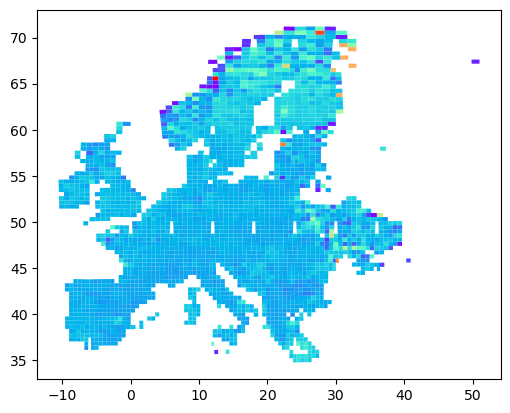

In [28]:
coordsvars.plot('hpnbreath_mean',cmap='rainbow')

In [29]:
import time
names=['DR','bodysize','cnrate','hnbreath','hnrate','hpnbreath','hpnrate','voltinism']
coords95=grid.copy(deep=True)
coordsvars95=grid.copy(deep=True)


aggregate={}
for ii,trait in enumerate(names):
    # create temp dataframe
    temp=pd.DataFrame(columns=[spp_list_dict[x] for x in alltraits95[trait].keys()], index=refdict.keys())
    for col in temp: # each column is a speci[es
        sppin=list(spp_dist[spp_dist['maps']==col]['CGRSNAME'].dropna().values) # list of gridnames where the species is present
        if len(sppin) > 0: # some species are in the distributions but not in the data
#             print(sppin)
            traitval=alltraits95[trait][col] if col in alltraits95[trait].keys() else np.nan
            temp.loc[sppin,col]=traitval # temp has as index the gridnames and species as columns, I am "mapping" the trait values
    temp['%s_mean'%(trait)]=temp[temp.columns].mean(axis=1)
    temp['%s_median'%(trait)]=temp[[x for x in temp.columns if x not in ['mean']]].median(axis=1)
    temp1=coords95.join(temp[['%s_mean'%(trait),'%s_median'%(trait)]], on='CGRSNAME')
    coordsvars95=pd.concat([coordsvars95,temp1])
#     print(trait)
coordsvars95

CGRSNAME               CGRSTYPE  \
0       24NSF3  independent seam cell   
1       24NSF4  independent seam cell   
2       24NSG3  independent seam cell   
3       24NSG4  independent seam cell   
4       24NSH3  independent seam cell   
...        ...                    ...   
35624   44XNS1  independent seam cell   
35625   44XNS2  independent seam cell   
35626   44XNT1  independent seam cell   
35627   44XNT2  independent seam cell   
35628   44XNU2  independent seam cell   

                                                geometry GridNr DR_mean  \
0      POLYGON ((-42.00000 0.45174, -42.00000 0.90348...    NaN     NaN   
1      POLYGON ((-42.00000 0.00000, -42.00000 0.45174...    NaN     NaN   
2      POLYGON ((-42.00000 1.35522, -42.00000 1.80696...    NaN     NaN   
3      POLYGON ((-42.00000 0.90348, -42.00000 1.35522...    NaN     NaN   
4      POLYGON ((-42.00000 2.25870, -42.00000 2.71043...    NaN     NaN   
...                                                  ...    ...     ...   
35624  POLYGON ((81.00000 82.40465, 81.00000 82.85256...    NaN     NaN   
35625  POLYGON ((81.00000 81.95674, 81.00000 82.40465...    NaN     NaN   
35626  POLYGON ((81.00000 83.30046, 81.00000 83.74835...    NaN     NaN   
35627  POLYGON ((81.00000 82.85256, 81.00000 83.30046...    NaN     NaN   
35628  POLYGON ((81.00000 83.74835, 81.00000 84.19662...    NaN     NaN   

      DR_median bodysize_mean bodysize_median cnrate_mean cnrate_median  \
0           NaN           NaN             NaN         NaN           NaN   
1           NaN           NaN             NaN         NaN           NaN   
2           NaN           NaN             NaN         NaN           NaN   
3           NaN           NaN             NaN         NaN           NaN   
4           NaN           NaN             NaN         NaN           NaN   
...         ...           ...             ...         ...           ...   
35624       NaN           NaN             NaN         NaN           NaN   
35625       NaN           NaN             NaN         NaN           NaN   
35626       NaN           NaN             NaN         NaN           NaN   
35627       NaN           NaN             NaN         NaN           NaN   
35628       NaN           NaN             NaN         NaN           NaN   

      hnbreath_mean hnbreath_median hnrate_mean hnrate_median hpnbreath_mean  \
0               NaN             NaN         NaN           NaN            NaN   
1               NaN             NaN         NaN           NaN            NaN   
2               NaN             NaN         NaN           NaN            NaN   
3               NaN             NaN         NaN           NaN            NaN   
4               NaN             NaN         NaN           NaN            NaN   
...             ...             ...         ...           ...            ...   
35624           NaN             NaN         NaN           NaN            NaN   
35625           NaN             NaN         NaN           NaN            NaN   
35626           NaN             NaN         NaN           NaN            NaN   
35627           NaN             NaN         NaN           NaN            NaN   
35628           NaN             NaN         NaN           NaN            NaN   

      hpnbreath_median hpnrate_mean hpnrate_median voltinism_mean  \
0                  NaN          NaN            NaN            NaN   
1                  NaN          NaN            NaN            NaN   
2                  NaN          NaN            NaN            NaN   
3                  NaN          NaN            NaN            NaN   
4                  NaN          NaN            NaN            NaN   
...                ...          ...            ...            ...   
35624              NaN          NaN            NaN            NaN   
35625              NaN          NaN            NaN            NaN   
35626              NaN          NaN            NaN            NaN   
35627              NaN          NaN            NaN          

In [30]:
coordsvars95[[ 'DR_mean', 'DR_median',
       'bodysize_mean', 'bodysize_median', 'cnrate_mean', 'cnrate_median',
       'hnbreath_mean', 'hnbreath_median', 'hnrate_mean', 'hnrate_median',
       'hpnbreath_mean', 'hpnbreath_median', 'hpnrate_mean', 'hpnrate_median',
       'voltinism_mean', 'voltinism_median']]=coordsvars95[[ 'DR_mean', 'DR_median',
       'bodysize_mean', 'bodysize_median', 'cnrate_mean', 'cnrate_median',
       'hnbreath_mean', 'hnbreath_median', 'hnrate_mean', 'hnrate_median',
       'hpnbreath_mean', 'hpnbreath_median', 'hpnrate_mean', 'hpnrate_median',
       'voltinism_mean', 'voltinism_median']].astype('float')

<Axes: >

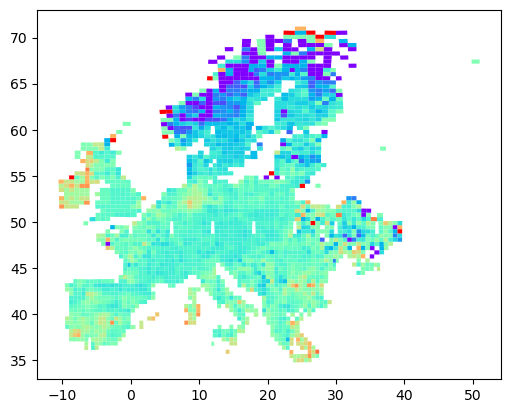

In [31]:
coordsvars95.plot('voltinism_mean',cmap='rainbow')

<Axes: >

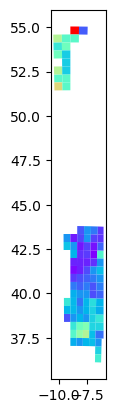

In [32]:
test=coordsvars95[~coordsvars95['GridNr'].isna()]
test[test['GridNr']<170].plot('voltinism_mean',cmap='rainbow')

In [33]:
# get geometry coords
coord_list = [str(x) for x in coordsvars95['geometry']]
print(test[test['GridNr']<170]['geometry'].head(1))
coord_list[0]

5008    POLYGON ((-24.85031 65.35747, -24.81297 65.805...
Name: geometry, dtype: geometry


'POLYGON ((-42 0.45174, -42 0.90348, -41.69536 0.90372, -41.69511 0.45186, -42 0.45174))'

In [34]:
test[test['GridNr']<170]['geometry']

5008     POLYGON ((-24.85031 65.35747, -24.81297 65.805...
6552     POLYGON ((-23.01342 63.56396, -23.04565 64.012...
6554     POLYGON ((-22.00699 63.57455, -22.02312 64.023...
6588     POLYGON ((-21.00000 63.57808, -21.00000 64.026...
6589     POLYGON ((-21.00000 63.12934, -21.00000 63.578...
                               ...                        
9817     POLYGON ((-9.00000 54.59747, -9.00000 55.04681...
9818     POLYGON ((-9.00000 54.14810, -9.00000 54.59747...
9819     POLYGON ((-8.22613 54.59500, -8.21750 55.04429...
17952    POLYGON ((19.28255 38.38564, 19.27177 38.83603...
17986    POLYGON ((19.85490 38.39263, 19.84771 38.84313...
Name: geometry, Length: 1458, dtype: geometry

In [35]:
coord_list[1000].split(',')[4].split(' ')[2].strip(')')

'33.88918'

In [37]:
# the polygon is closed and the fifth set of coordinates is the same as the first one
# each duple corresponds to x,y
# the 4th item corresponds to the bottom left corner of the pixel
# meaning it is minx and miny
coord_list[1000]

'POLYGON ((-38.45927 33.88918, -38.4564 34.3401, -37.91286 34.33648, -37.91861 33.88562, -38.45927 33.88918))'

In [38]:
coord_list[1000].split(',')[4] # this is the fourth item, corresponding to minx,miny

' -38.45927 33.88918))'

In [42]:
coord_list[1000].split(',')[4].split(' ') # splits into three items one of them is a space (in the zeroth position)
coord_list[1000].split(',')[4].split(' ')[1]

'-38.45927'

In [48]:
miny_list=[float(x.split(',')[4].split(' ')[2].strip(')')) for x in coord_list]
print(miny_list[0:10])
print(len(miny_list))
miny_list

coordsvars95['miny']=miny_list
coordsvars['miny']=miny_list

[0.45174, 0.0, 1.35522, 0.90348, 2.2587, 1.80696, 3.16217, 2.71043, 0.45186, 0.0]
320661


In [46]:
minx_list=[float(x.split(',')[4].split(' ')[1]) for x in coord_list]
print(minx_list[0:10])
print(len(minx_list))
minx_list

coordsvars95['minx']=minx_list
coordsvars['minx']=minx_list

[-42.0, -42.0, -42.0, -42.0, -42.0, -42.0, -42.0, -42.0, -41.69511, -41.69502]
320661


In [49]:
coordsvars['miny'].describe()

count    320661.000000
mean         32.347555
std          21.361483
min           0.000000
25%          14.456200
50%          29.821350
75%          48.285420
max          83.748350
Name: miny, dtype: float64

In [50]:
coordsvars['minx'].describe()

count    320661.000000
mean         20.840150
std          36.380038
min         -42.000030
25%         -10.750510
50%          21.000000
75%          52.353920
max          85.189030
Name: minx, dtype: float64

<Axes: >

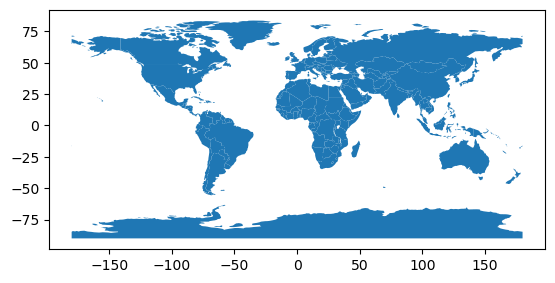

In [51]:
# worldLAEA.columns
# for index, row in worldLAEA.iterrows():
#     print(row.geoms)
world = gpd.read_file('./cgrs_grid/ne_110m_admin_0_countries_lakes.shp', geometry='geometry')

type(world)
type(world['geometry'])
world['geometry'].dtypes

#     gplt.polyplot(row.geoms,zorder=1, linewidth=0.2,extent=(-15, 35, 30, 71), facecolor='none', ax=ax)
world.plot()

# Figures!

EPSG:4326


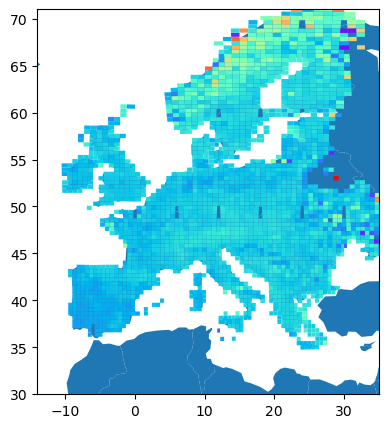

In [196]:
print(world.crs)

worldLAEA = world.to_crs(grid.crs)
worldLAEA.crs

fig,ax=plt.subplots(figsize=(5,5))
# gplt.polyplot(worldLAEA,zorder=1, linewidth=0.2,extent=(-15, 35, 30, 71), facecolor='none', ax=ax)
worldLAEA.plot(ax=ax)
coordsvars95.plot('%s_mean'%('DR'),cmap='rainbow', zorder=2, ax=ax)
ax.set_xlim(-14,35)
ax.set_ylim(30,71)
plt.show()

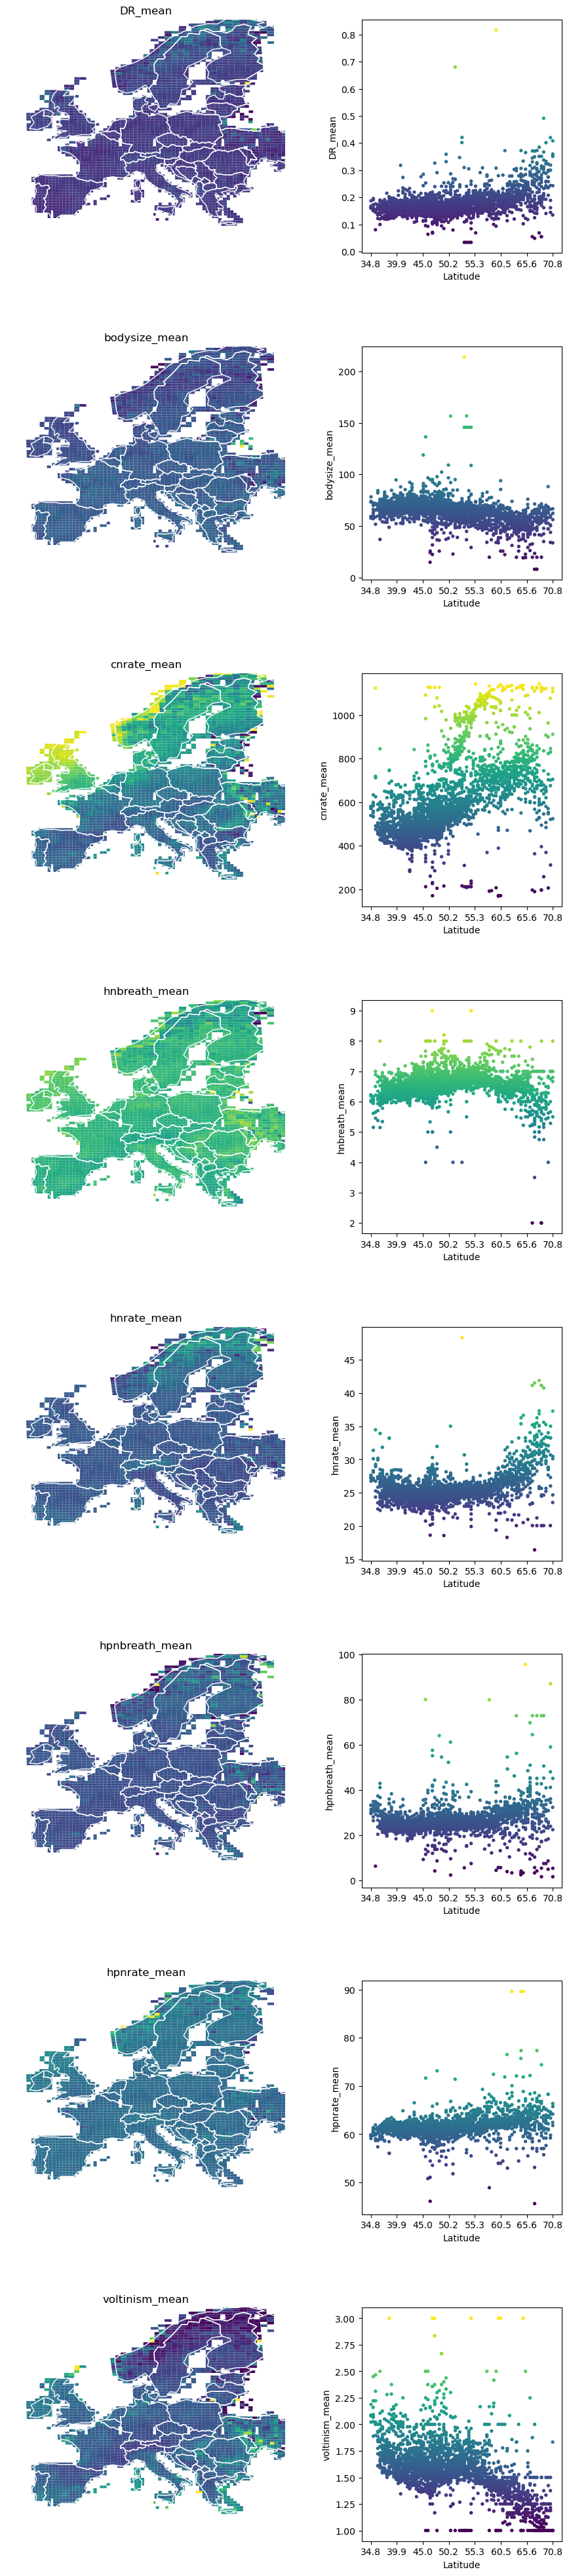

In [199]:
names=['DR','bodysize','cnrate','hnbreath','hnrate','hpnbreath','hpnrate','voltinism']
markersize=3
cmap = mpl.cm.get_cmap('viridis')

fig=plt.figure(figsize=(11,50),facecolor='w') #width height
outer_grid=gridspec.GridSpec(len(names),2, wspace=0.3, hspace=0.4, width_ratios=[1,0.7]) #row columns

for index,trait in enumerate(names):
    ax=plt.subplot(outer_grid[index,0])#, projection=gcrs.LambertAzimuthalEqualArea())# row column
    ax.set_xlim(-14,35)
    ax.set_ylim(30,71)
#     coordsvars95.plot('%s_mean'%(trait),cmap=cmap, zorder=1, ax=ax)
    coordsvars.plot('%s_mean'%(trait),cmap=cmap, zorder=1, ax=ax)
    
    worldLAEA.plot(ax=ax, zorder=2, linewidth=0.2, lw=1, edgecolor = '#ffffff', facecolor='none')

#     gplt.polyplot(world, zorder=2, linewidth=0.2, lw=1, extent=(-15, 35, 40, 71),
#                   edgecolor = '#ffffff', facecolor='none', ax=ax)
    [ax.spines[loc].set_visible(False) for loc in ['right','top', 'left','bottom']]
    ax.set_xticks([]); ax.set_yticks([])
    plt.title('%s_mean'%(trait))
    
    ax=plt.subplot(outer_grid[index,1])# row column
#     temp=coordsvars95.dropna(subset=['%s_mean'%(trait)],axis=0).sort_values('miny', ascending=True)
    temp=coordsvars.dropna(subset=['%s_mean'%(trait)],axis=0).sort_values('miny', ascending=True)
    norm = mpl.colors.Normalize(vmin=temp['%s_mean'%(trait)].min(), vmax=temp['%s_mean'%(trait)].max())
    ax.scatter(x=temp['miny'], y=temp['%s_mean'%(trait)], c=[norm(x) for x in temp['%s_mean'%(trait)]],cmap = cmap, marker='o', s=8)
    ticks=[x for x in np.linspace(temp['miny'].min(),temp['miny'].max(),8)]
    ax.set_xticks(ticks,['%.1f'%(x) for x in ticks])
    plt.ylabel('%s_mean'%(trait))
    plt.xlabel('Latitude')

# plt.savefig('./butterflies_traitmeans_90data_20221027.svg',dpi=300)
# plt.savefig('./butterflies_traitmeans_90data_20221027.pdf',dpi=300)
# plt.savefig('./butterflies_traitmeans_90data_20221027.png',dpi=300)
# plt.savefig('./butterflies_traitmeans_alldata_20221027.svg',dpi=300)
# plt.savefig('./butterflies_traitmeans_alldata_20221027.pdf',dpi=300)
# plt.savefig('./butterflies_traitmeans_alldata_20221027.png',dpi=300)

plt.show()

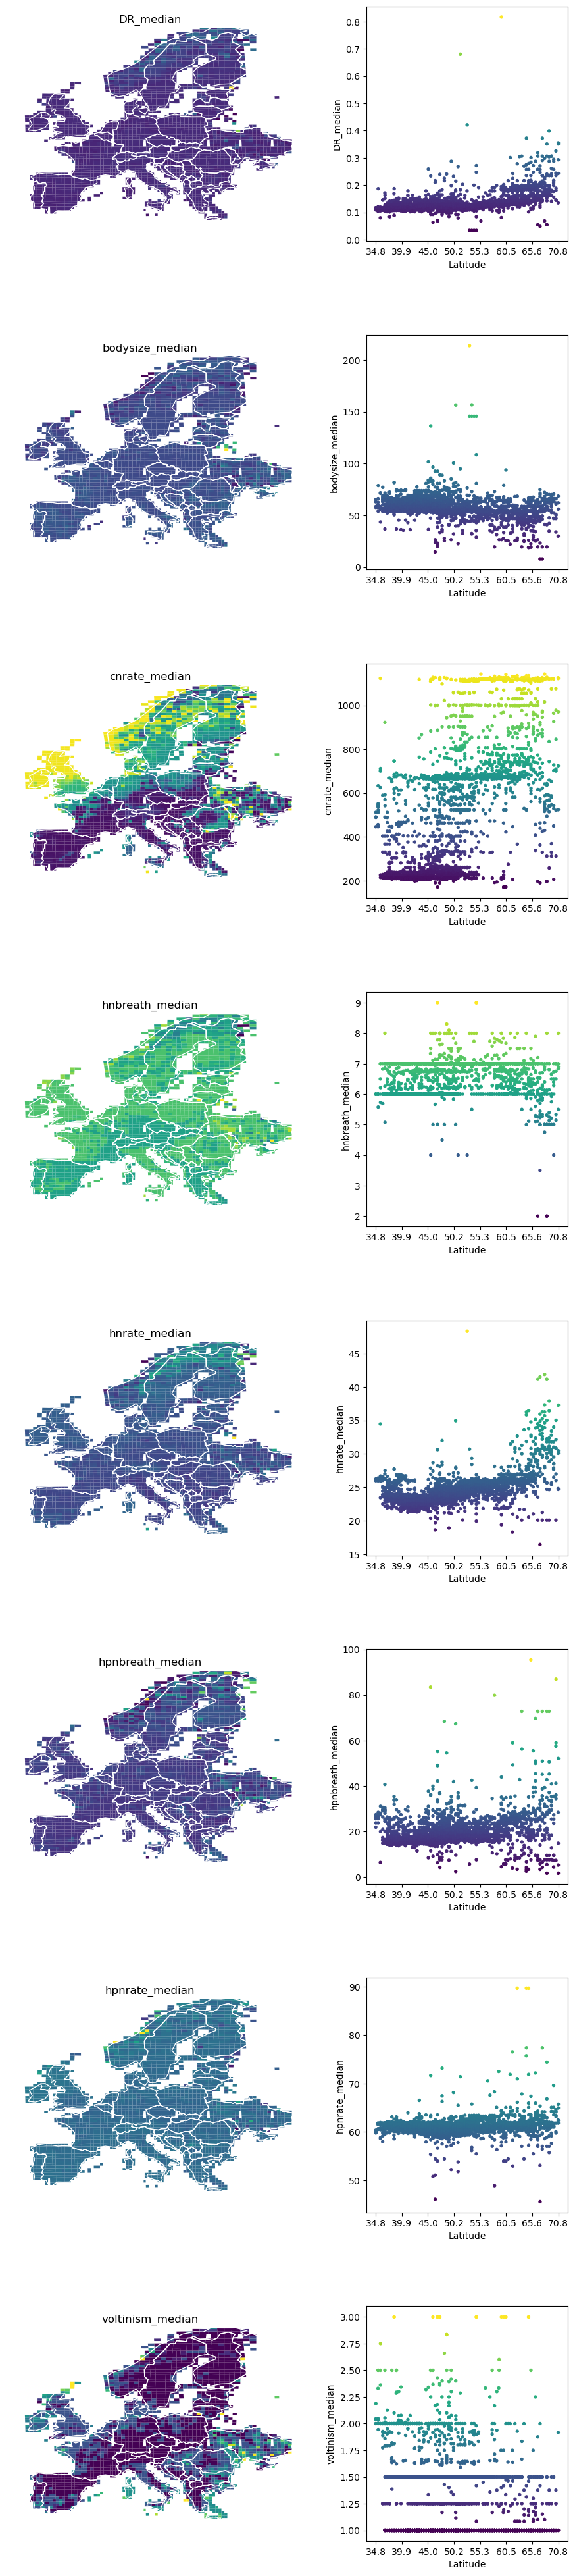

In [200]:
names=['DR','bodysize','cnrate','hnbreath','hnrate','hpnbreath','hpnrate','voltinism']
markersize=3
cmap = mpl.cm.get_cmap('viridis')

fig=plt.figure(figsize=(11,50),facecolor='w') #width height
outer_grid=gridspec.GridSpec(len(names),2, wspace=0.3, hspace=0.4, width_ratios=[1,0.7]) #row columns

for index,trait in enumerate(names):
    ax=plt.subplot(outer_grid[index,0])#, projection=gcrs.LambertAzimuthalEqualArea())# row column
    ax.set_xlim(-14,40)
    ax.set_ylim(35,71)
#     coordsvars95.plot('%s_median'%(trait),cmap=cmap, zorder=1, ax=ax)
    coordsvars.plot('%s_median'%(trait),cmap=cmap, zorder=1, ax=ax)
    worldLAEA.plot(ax=ax, zorder=2, linewidth=0.2, lw=1, edgecolor = '#ffffff', facecolor='none')

#     gplt.polyplot(world, zorder=2, linewidth=0.2, lw=1, extent=(-15, 35, 40, 71),
#                   edgecolor = '#ffffff', facecolor='none', ax=ax)
    [ax.spines[loc].set_visible(False) for loc in ['right','top', 'left','bottom']]
    ax.set_xticks([]); ax.set_yticks([])
    plt.title('%s_median'%(trait))
    
    ax=plt.subplot(outer_grid[index,1])# row column
#     temp=coordsvars95.dropna(subset=['%s_median'%(trait)],axis=0).sort_values('miny', ascending=True)
    temp=coordsvars.dropna(subset=['%s_median'%(trait)],axis=0).sort_values('miny', ascending=True)
    norm = mpl.colors.Normalize(vmin=temp['%s_median'%(trait)].min(), vmax=temp['%s_median'%(trait)].max())
    ax.scatter(x=temp['miny'], y=temp['%s_median'%(trait)], c=[norm(x) for x in temp['%s_median'%(trait)]],cmap = cmap, marker='o', s=8)
    ticks=[x for x in np.linspace(temp['miny'].min(),temp['miny'].max(),8)]
    ax.set_xticks(ticks,['%.1f'%(x) for x in ticks])
    plt.ylabel('%s_median'%(trait))
    plt.xlabel('Latitude')

# plt.savefig('./butterflies_traitmedians_90data_20221027.svg',dpi=300)
# plt.savefig('./butterflies_traitmedians_90data_20221027.pdf',dpi=300)
# plt.savefig('./butterflies_traitmedians_90data_20221027.png',dpi=300)

# plt.savefig('./butterflies_traitmedians_alldata_20221027.svg',dpi=300)
# plt.savefig('./butterflies_traitmedians_alldata_20221027.pdf',dpi=300)
# plt.savefig('./butterflies_traitmedians_alldata_20221027.png',dpi=300)

plt.show()

In [52]:
# coordsvars95.to_csv('./traits_per_cell_within90dist_20221026.csv',sep='\t')
coordsvars95.to_csv('./traits_per_cell_within90dist_20230922.csv',sep='\t')

In [53]:
# coordsvars.to_csv('./traits_per_cell_fulldist_20221026.csv',sep='\t')
coordsvars.to_csv('./traits_per_cell_fulldist_20230922.csv',sep='\t')

# Log10 body size only for data within X distribution (90 now)

In [54]:
# TRANSFORM FIRST
bodysize['bodysize_log10']=''
bodysize.loc[bodysize.index,'bodysize_log10']=np.log10(bodysize['bodysize'])
bodysize.describe()

bodysize
count  315.000000
mean    67.576959
std     50.316253
min      6.512701
25%     33.907595
50%     55.732389
75%     83.349585
max    357.908968

In [55]:
variables=[DR,bodysize,cnrate,hnbreath,hnrate,hpnbreath,hpnrate,voltinism]
names=['DR','bodysize_log10','cnrate','hnbreath','hnrate','hpnbreath','hpnrate','voltinism'] # make sure this coincide with the headers in the tables

# making dict with data within a 95% range before transformation

alltraits95log={}
for index,data in enumerate(variables):
    q0225=data[names[index]].quantile(0.05) # not changing variable names but changing how much we trimmed
    q0975=data[names[index]].quantile(0.95) # not changing variable names but changing how much we trimmed
    
    temp = data[ (data[names[index]] > q0225) & (data[names[index]] < q0975)]
    alltraits95log[names[index]]=dict(zip(temp['traits'],temp[names[index]]))
# alltraits95log # this dict contains all data

In [56]:
import time
names=['DR','bodysize_log10','cnrate','hnbreath','hnrate','hpnbreath','hpnrate','voltinism']
coords90log=grid.copy(deep=True)
coordsvars90log=grid.copy(deep=True)

aggregate={}
for ii,trait in enumerate(names):
    # create temp dataframe
    temp=pd.DataFrame(columns=[spp_list_dict[x] for x in alltraits95log[trait].keys()], index=refdict.keys())
    for col in temp: # each column is a speci[es
        sppin=list(spp_dist[spp_dist['maps']==col]['CGRSNAME'].dropna().values) # list of gridnames where the species is present
        if len(sppin) > 0: # some species are in the distributions but not in the data
#             print(sppin)
            traitval=alltraits95log[trait][col] if col in alltraits95log[trait].keys() else np.nan
            temp.loc[sppin,col]=traitval # temp has as index the gridnames and species as columns, I am "mapping" the trait values
    temp['%s_mean'%(trait)]=temp[temp.columns].mean(axis=1)
    temp['%s_median'%(trait)]=temp[[x for x in temp.columns if x not in ['mean']]].median(axis=1)
    temp1=coords90log.join(temp[['%s_mean'%(trait),'%s_median'%(trait)]], on='CGRSNAME')
    coordsvars90log=pd.concat([coordsvars90log,temp1])
#     print(trait)
coordsvars90log

CGRSNAME               CGRSTYPE  \
0       24NSF3  independent seam cell   
1       24NSF4  independent seam cell   
2       24NSG3  independent seam cell   
3       24NSG4  independent seam cell   
4       24NSH3  independent seam cell   
...        ...                    ...   
35624   44XNS1  independent seam cell   
35625   44XNS2  independent seam cell   
35626   44XNT1  independent seam cell   
35627   44XNT2  independent seam cell   
35628   44XNU2  independent seam cell   

                                                geometry GridNr DR_mean  \
0      POLYGON ((-42.00000 0.45174, -42.00000 0.90348...    NaN     NaN   
1      POLYGON ((-42.00000 0.00000, -42.00000 0.45174...    NaN     NaN   
2      POLYGON ((-42.00000 1.35522, -42.00000 1.80696...    NaN     NaN   
3      POLYGON ((-42.00000 0.90348, -42.00000 1.35522...    NaN     NaN   
4      POLYGON ((-42.00000 2.25870, -42.00000 2.71043...    NaN     NaN   
...                                                  ...    ...     ...   
35624  POLYGON ((81.00000 82.40465, 81.00000 82.85256...    NaN     NaN   
35625  POLYGON ((81.00000 81.95674, 81.00000 82.40465...    NaN     NaN   
35626  POLYGON ((81.00000 83.30046, 81.00000 83.74835...    NaN     NaN   
35627  POLYGON ((81.00000 82.85256, 81.00000 83.30046...    NaN     NaN   
35628  POLYGON ((81.00000 83.74835, 81.00000 84.19662...    NaN     NaN   

      DR_median bodysize_log10_mean bodysize_log10_median cnrate_mean  \
0           NaN                 NaN                   NaN         NaN   
1           NaN                 NaN                   NaN         NaN   
2           NaN                 NaN                   NaN         NaN   
3           NaN                 NaN                   NaN         NaN   
4           NaN                 NaN                   NaN         NaN   
...         ...                 ...                   ...         ...   
35624       NaN                 NaN                   NaN         NaN   
35625       NaN                 NaN                   NaN         NaN   
35626       NaN                 NaN                   NaN         NaN   
35627       NaN                 NaN                   NaN         NaN   
35628       NaN                 NaN                   NaN         NaN   

      cnrate_median hnbreath_mean hnbreath_median hnrate_mean hnrate_median  \
0               NaN           NaN             NaN         NaN           NaN   
1               NaN           NaN             NaN         NaN           NaN   
2               NaN           NaN             NaN         NaN           NaN   
3               NaN           NaN             NaN         NaN           NaN   
4               NaN           NaN             NaN         NaN           NaN   
...             ...           ...             ...         ...           ...   
35624           NaN           NaN             NaN         NaN           NaN   
35625           NaN           NaN             NaN         NaN           NaN   
35626           NaN           NaN             NaN         NaN           NaN   
35627           NaN           NaN             NaN         NaN           NaN   
35628           NaN           NaN             NaN         NaN           NaN   

      hpnbreath_mean hpnbreath_median hpnrate_mean hpnrate_median  \
0                NaN              NaN          NaN            NaN   
1                NaN              NaN          NaN            NaN   
2                NaN              NaN          NaN            NaN   
3                NaN              NaN          NaN            NaN   
4                NaN              NaN          NaN            NaN   
...              ...              ...          ...            ...   
35624            NaN              NaN          NaN            NaN   
35625            NaN              NaN          NaN            NaN   
35626            NaN              NaN          NaN            NaN   
35627            NaN              NaN          NaN            NaN   
35628            NaN       

In [57]:
coordsvars90log.columns

Index(['CGRSNAME', 'CGRSTYPE', 'geometry', 'GridNr', 'DR_mean', 'DR_median',
       'bodysize_log10_mean', 'bodysize_log10_median', 'cnrate_mean',
       'cnrate_median', 'hnbreath_mean', 'hnbreath_median', 'hnrate_mean',
       'hnrate_median', 'hpnbreath_mean', 'hpnbreath_median', 'hpnrate_mean',
       'hpnrate_median', 'voltinism_mean', 'voltinism_median'],
      dtype='object')

In [58]:
# get geometry coords
coord_list = [str(x) for x in coordsvars90log['geometry']]
print(test[test['GridNr']<170]['geometry'].head(1))
coord_list[0]
miny_list=[float(x.split(',')[4].split(' ')[2].strip(')')) for x in coord_list]
minx_list=[float(x.split(',')[4].split(' ')[1]) for x in coord_list]
print(miny_list[0:10])
print(minx_list[0:10])
print(len(miny_list))
print(len(minx_list))
miny_list
minx_list

coordsvars90log['miny']=miny_list
coordsvars90log['minx']=minx_list

5008    POLYGON ((-24.85031 65.35747, -24.81297 65.805...
Name: geometry, dtype: geometry
[0.45174, 0.0, 1.35522, 0.90348, 2.2587, 1.80696, 3.16217, 2.71043, 0.45186, 0.0]
[-42.0, -42.0, -42.0, -42.0, -42.0, -42.0, -42.0, -42.0, -41.69511, -41.69502]
320661
320661


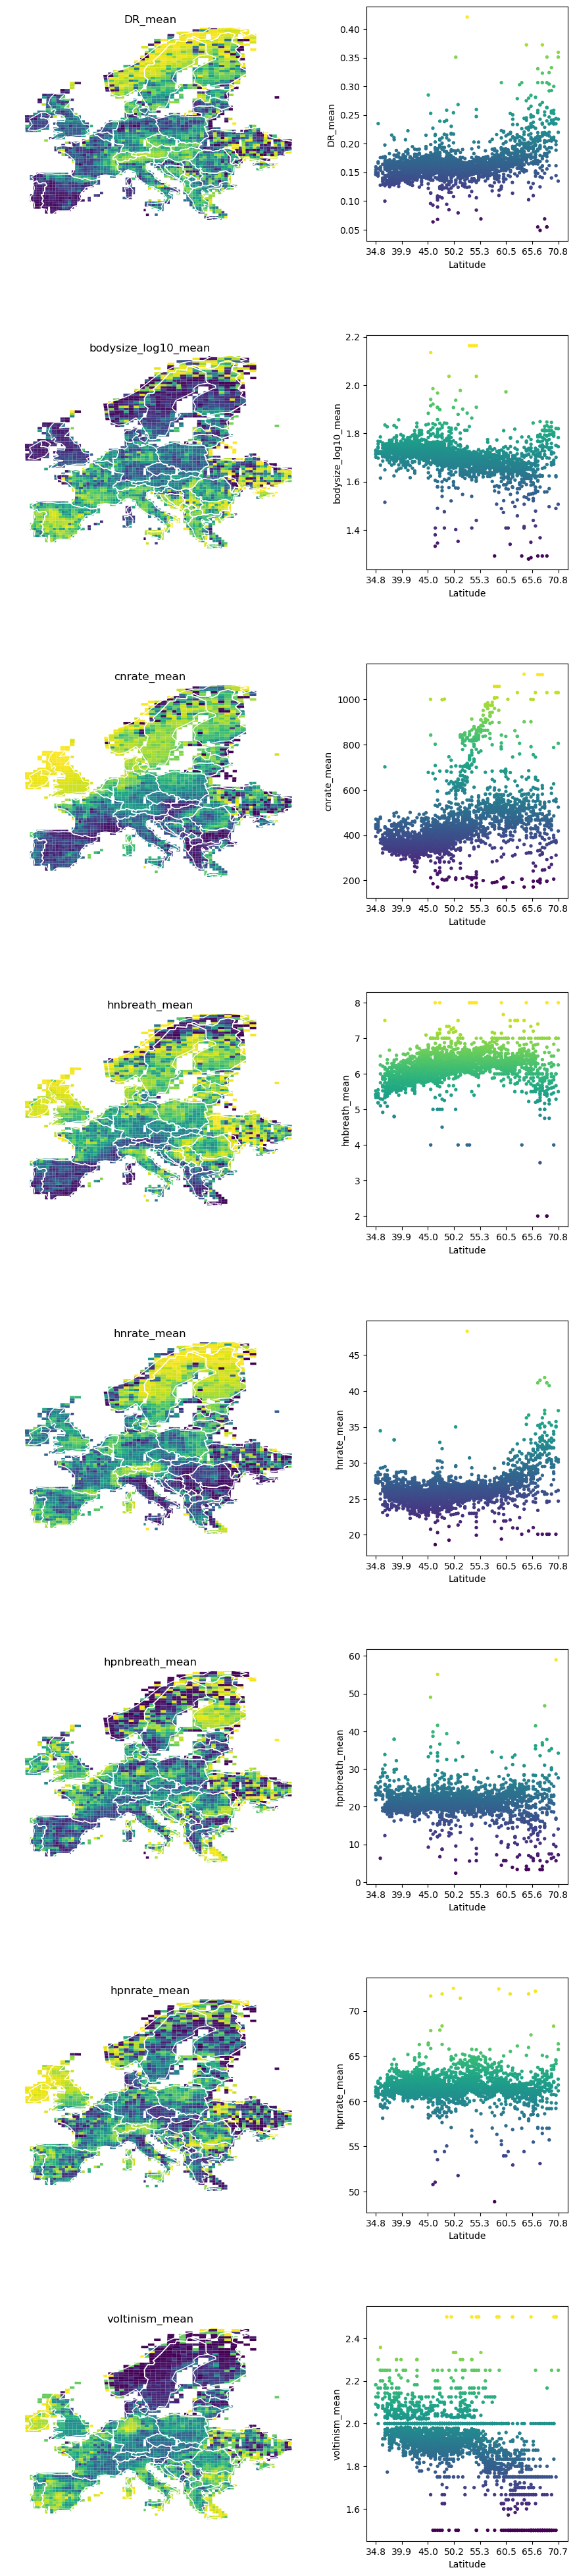

In [206]:
names=['DR','bodysize_log10','cnrate','hnbreath','hnrate','hpnbreath','hpnrate','voltinism']
markersize=3
cmap = mpl.cm.get_cmap('viridis')

fig=plt.figure(figsize=(11,50),facecolor='w') #width height
outer_grid=gridspec.GridSpec(len(names),2, wspace=0.3, hspace=0.4, width_ratios=[1,0.7]) #row columns

for index,trait in enumerate(names):
    ax=plt.subplot(outer_grid[index,0])#, projection=gcrs.LambertAzimuthalEqualArea())# row column
    ax.set_xlim(-14,40)
    ax.set_ylim(35,71)
    coordsvars90log.plot('%s_mean'%(trait),cmap=cmap, zorder=1, ax=ax)
    worldLAEA.plot(ax=ax, zorder=2, linewidth=0.2, lw=1, edgecolor = '#ffffff', facecolor='none')

#     gplt.polyplot(world, zorder=2, linewidth=0.2, lw=1, extent=(-15, 35, 40, 71),
#                   edgecolor = '#ffffff', facecolor='none', ax=ax)
    [ax.spines[loc].set_visible(False) for loc in ['right','top', 'left','bottom']]
    ax.set_xticks([]); ax.set_yticks([])
    plt.title('%s_mean'%(trait))
    
    ax=plt.subplot(outer_grid[index,1])# row column
    temp=coordsvars90log.dropna(subset=['%s_mean'%(trait)],axis=0).sort_values('miny', ascending=True)
    norm = mpl.colors.Normalize(vmin=temp['%s_mean'%(trait)].min(), vmax=temp['%s_mean'%(trait)].max())
    ax.scatter(x=temp['miny'], y=temp['%s_mean'%(trait)], c=[norm(x) for x in temp['%s_mean'%(trait)]],cmap = cmap, marker='o', s=8)
    ticks=[x for x in np.linspace(temp['miny'].min(),temp['miny'].max(),8)]
    ax.set_xticks(ticks,['%.1f'%(x) for x in ticks])
    plt.ylabel('%s_mean'%(trait))
    plt.xlabel('Latitude')

# plt.savefig('./butterflies_traitmeans_90data_logBS_20221027.svg',dpi=300)
# plt.savefig('./butterflies_traitmeans_90data_logBS_20221027.pdf',dpi=300)
# plt.savefig('./butterflies_traitmeans_90data_logBS_20221027.png',dpi=300)
# plt.savefig('./butterflies_traitmeans_alldata_20221027.svg',dpi=300)
# plt.savefig('./butterflies_traitmeans_alldata_20221027.pdf',dpi=300)
# plt.savefig('./butterflies_traitmeans_alldata_20221027.png',dpi=300)

plt.show()

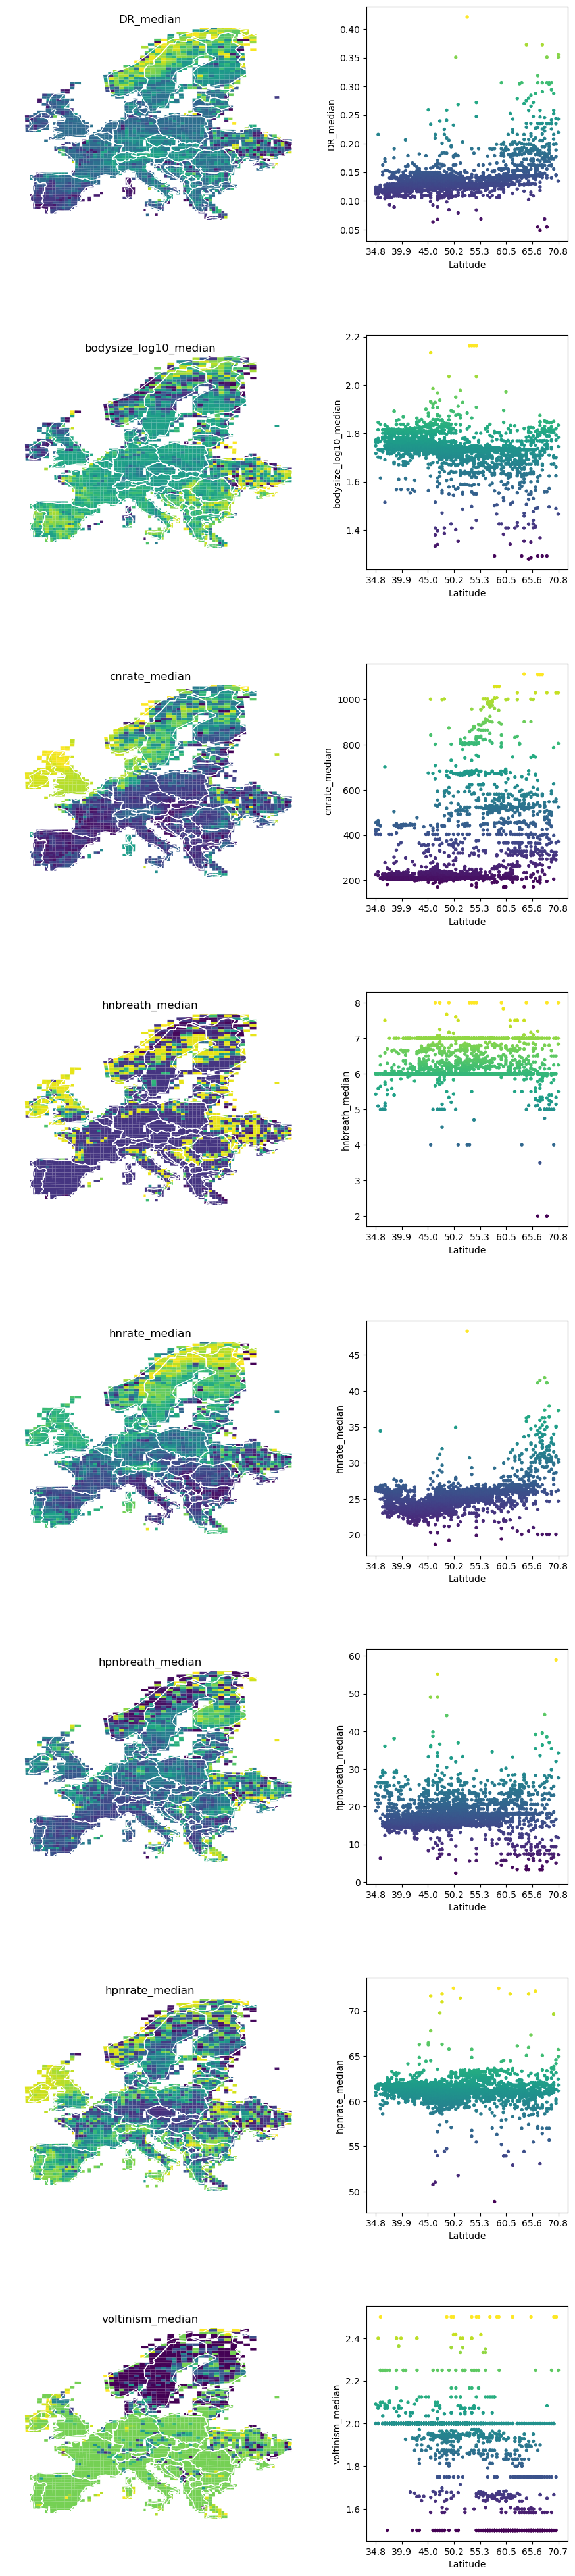

In [207]:
names=['DR','bodysize_log10','cnrate','hnbreath','hnrate','hpnbreath','hpnrate','voltinism']
markersize=3
cmap = mpl.cm.get_cmap('viridis')

fig=plt.figure(figsize=(11,50),facecolor='w') #width height
outer_grid=gridspec.GridSpec(len(names),2, wspace=0.3, hspace=0.4, width_ratios=[1,0.7]) #row columns

for index,trait in enumerate(names):
    ax=plt.subplot(outer_grid[index,0])#, projection=gcrs.LambertAzimuthalEqualArea())# row column
    ax.set_xlim(-14,40)
    ax.set_ylim(35,71)
    coordsvars90log.plot('%s_median'%(trait),cmap=cmap, zorder=1, ax=ax)
    worldLAEA.plot(ax=ax, zorder=2, linewidth=0.2, lw=1, edgecolor = '#ffffff', facecolor='none')

#     gplt.polyplot(world, zorder=2, linewidth=0.2, lw=1, extent=(-15, 35, 40, 71),
#                   edgecolor = '#ffffff', facecolor='none', ax=ax)
    [ax.spines[loc].set_visible(False) for loc in ['right','top', 'left','bottom']]
    ax.set_xticks([]); ax.set_yticks([])
    plt.title('%s_median'%(trait))
    
    ax=plt.subplot(outer_grid[index,1])# row column
    temp=coordsvars90log.dropna(subset=['%s_median'%(trait)],axis=0).sort_values('miny', ascending=True)
    norm = mpl.colors.Normalize(vmin=temp['%s_median'%(trait)].min(), vmax=temp['%s_median'%(trait)].max())
    ax.scatter(x=temp['miny'], y=temp['%s_median'%(trait)], c=[norm(x) for x in temp['%s_median'%(trait)]],cmap = cmap, marker='o', s=8)
    ticks=[x for x in np.linspace(temp['miny'].min(),temp['miny'].max(),8)]
    ax.set_xticks(ticks,['%.1f'%(x) for x in ticks])
    plt.ylabel('%s_median'%(trait))
    plt.xlabel('Latitude')

# plt.savefig('./butterflies_traitmedians_90data_logBS_20221027.svg',dpi=300)
# plt.savefig('./butterflies_traitmedians_90data_logBS_20221027.pdf',dpi=300)
# plt.savefig('./butterflies_traitmedians_90data_logBS_20221027.png',dpi=300)
# plt.savefig('./butterflies_traitmeans_alldata_20221027.svg',dpi=300)
# plt.savefig('./butterflies_traitmeans_alldata_20221027.pdf',dpi=300)
# plt.savefig('./butterflies_traitmeans_alldata_20221027.png',dpi=300)

plt.show()

In [59]:
coordsvars90log.columns
print(len(coordsvars90log))
print(len(coordsvars95))
coordsvars90log['bodysize_median']=coordsvars95['bodysize_median']
coordsvars90log['bodysize_mean']=coordsvars95['bodysize_mean']
# coordsvars90log.to_csv('./traits_per_cell_90dist_log10BS_20221026.csv',sep='\t')
coordsvars90log.to_csv('./traits_per_cell_90dist_log10BS_20230922.csv',sep='\t') # with minx

320661
320661


In [60]:
coordsvars90log.columns

Index(['CGRSNAME', 'CGRSTYPE', 'geometry', 'GridNr', 'DR_mean', 'DR_median',
       'bodysize_log10_mean', 'bodysize_log10_median', 'cnrate_mean',
       'cnrate_median', 'hnbreath_mean', 'hnbreath_median', 'hnrate_mean',
       'hnrate_median', 'hpnbreath_mean', 'hpnbreath_median', 'hpnrate_mean',
       'hpnrate_median', 'voltinism_mean', 'voltinism_median', 'miny', 'minx',
       'bodysize_median', 'bodysize_mean'],
      dtype='object')